In [1]:
import numpy as np 
import pandas as pd 
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
import os
import cv2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_SIZE = 224
NUM_CLASSES = 120
SEED = 19
data_dir = 'dog_breed'
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
sample_sub = pd.read_csv(os.path.join(data_dir,'sample_submission.csv'))

print(len(os.listdir(os.path.join(data_dir, 'train'))), len(labels))
print(len(os.listdir(os.path.join(data_dir, 'test'))))

10222 10222
10357


In [3]:
targets_series = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [4]:
im_size = 90

In [5]:
x_train = []
y_train = []
x_test = []

i = 0 
for f, breed in labels.values:
    img = cv2.imread('dog_breed/train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1

In [6]:
for f in sample_sub['id'].values:
    img = cv2.imread('dog_breed/test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))

In [7]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

(10222, 90, 90, 3)
(10222, 120)
(10357, 90, 90, 3)


In [8]:
num_class = y_train_raw.shape[1]

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)

In [10]:
# Create the base pre-trained model
# Can't download weights in the kernel
base_model = VGG19(weights='imagenet',include_top=False, input_shape=(im_size, im_size, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90, 90, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 90, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 90, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 22, 128)       0         
__________

In [11]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), verbose=1)

Train on 7155 samples, validate on 3067 samples
Epoch 1/10
7155/7155 [==============================] - 27s 4ms/step - loss: 4.6211 - acc: 0.0474 - val_loss: 4.3073 - val_acc: 0.0760
Epoch 2/10
7155/7155 [==============================] - 25s 3ms/step - loss: 3.6143 - acc: 0.1954 - val_loss: 4.1265 - val_acc: 0.1066
Epoch 3/10
7155/7155 [==============================] - 25s 4ms/step - loss: 3.1135 - acc: 0.2925 - val_loss: 4.0582 - val_acc: 0.1086
Epoch 4/10
7155/7155 [==============================] - 25s 4ms/step - loss: 2.7329 - acc: 0.3855 - val_loss: 4.0538 - val_acc: 0.1239
Epoch 5/10
7155/7155 [==============================] - 25s 4ms/step - loss: 2.4529 - acc: 0.4601 - val_loss: 4.0350 - val_acc: 0.1294
Epoch 6/10
7155/7155 [==============================] - 25s 4ms/step - loss: 2.1945 - acc: 0.5241 - val_loss: 3.9911 - val_acc: 0.1363
Epoch 7/10
7155/7155 [==============================] - 25s 4ms/step - loss: 1.9857 - acc: 0.5857 - val_loss: 4.0167 - val_acc: 0.1347
Epoch 8

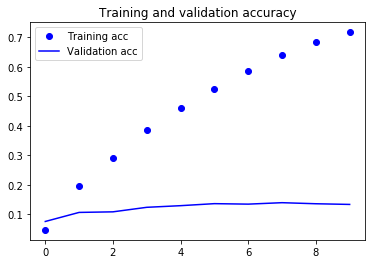

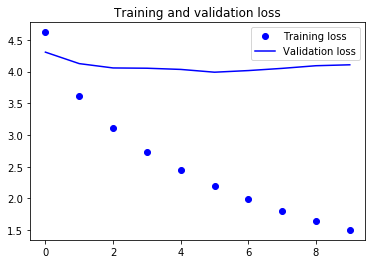

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()